In [1]:
%matplotlib inline


# Getting started tutorial

In this introductory example, you will see how to use the :code:`spikeinterface` to perform a full electrophysiology analysis.
We will first create some simulated data, and we will then perform some pre-processing, run a couple of spike sorting
algorithms, inspect and validate the results, export to Phy, and compare spike sorters.


In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [4]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [5]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [6]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [7]:
import spikeinterface.full as si

## Part 1: Importing Data

- Looking over the metadata file

In [99]:
with open("./data/02122021_BLA4-1_1v2_Competition_Day1.info.dat") as info_file:
    lines = info_file.readlines()
    for line in lines:
        print(line)

<Start settings>

Description: Channel info for PHY data

Byte_order: little endian

Original_file: 02122021_BLA4-1_1v2_Competition_Day1.rec

Clock rate: 20000

Decimation: 1

Number_of_channels: 32

Fields: <nTrode int16><nTrodeChannel int16>

<End settings>

                       	   

         

                                                             


- Reading in the data into Spikeinterface

In [103]:
recording = se.read_spikegadgets("./data/02122021_BLA4-1_1v2_Competition_Day1.rec"f)

This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


In [104]:
type(recording)

spikeinterface.extractors.neoextractors.spikegadgets.SpikeGadgetsRecordingExtractor

:code:`recording` is a :code:`RecordingExtractor` object, which extracts information about channel ids, channel locations
(if present), the sampling frequency of the recording, and the extracellular  traces. :code:`sorting_true` is a
:code:`SortingExtractor` object, which contains information about spike-sorting related information,  including unit ids,
spike trains, etc. Since the data are simulated, :code:`sorting_true` has ground-truth information of the spiking
activity of each unit.

Let's use the :code:`widgets` module to visualize the traces and the raster plots.



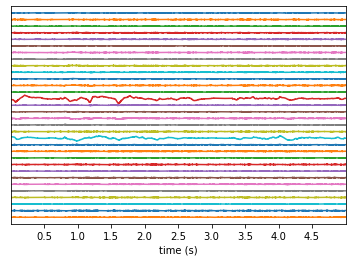

In [105]:
w_ts = sw.plot_timeseries(recording, time_range=(0, 5))


This is how you retrieve info from a :code:`RecordingExtractor`...



In [253]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()
duration = recording.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31']
Sampling frequency: 20000.0
Number of channels: 32
Number of segments: 1
Duration: 66378757
Number of hours: 0.9219271805555554


...and a :code:`SortingExtractor`



In [107]:
num_seg = recording.get_num_segments()

print('Number of segments:', num_seg)

Number of segments: 1


:code:`spikeinterface` internally uses the :code:`probeinterface`
to handle Probe and ProbeGroup.
 So any probe in the probeinterface collections can be download
and set to a Recording object.
In this case, the MEArec dataset already handles a Probe and we don't need to set it.



Using the :code:`toolkit`, you can perform preprocessing on the recordings.
Each pre-processing function also returns a :code:`RecordingExtractor`,
which makes it easy to build pipelines. Here, we filter the recording and
apply common median reference (CMR).
All theses preprocessing steps are "lazy". The computation is done on demand when we call
`recording.get_traces(...)` or when we save the object to disk.



# Setting Probes

In [108]:
# importing the module
import json

In [109]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe

## Opening up relevant Probe Metadata

In [110]:
with open("./data/nancyparameters.prm") as info_file:
    lines = info_file.readlines()
    for line in lines:
        print(line)

experiment_name = '02122021_BLA4-1_1v2_Competition_Day1.phy'

prb_file = 'nancyprobe_linearprobelargespace.prb'  # or the path to your PRB file



traces = dict(

    raw_data_files=[experiment_name + '.dat'],  # path to your .dat file(s)

    sample_rate=20000,  # sampling rate in Hz

    n_channels=32,  # number of channels in the .dat files

    dtype='int16',  # the data type used in the .dat files

)



# Parameters for the spike detection process.

spikedetekt = dict(



    filter_high_factor=0.95 * .5,

    filter_butter_order=3,  # Order of Butterworth filter.





    chunk_size_seconds=1,

    chunk_overlap_seconds=.015,



    n_excerpts=50,

    excerpt_size_seconds=1,

    threshold_strong_std_factor=3.5,

    threshold_weak_std_factor=3,

    detect_spikes='positive',

    use_single_threshold=True,

    connected_component_join_size=1,



    extract_s_before=10,

    extract_s_after=15,



    n_features_per_channel=3,  # Number of features per channel.

    pca_n_wave

In [111]:
with open("./data/nancyprobe_linearprobelargespace.prb") as info_file:
    lines = info_file.readlines()
    for line in lines:
        print(line)

channel_groups = {0: {'channels': [0,

                  1,

                  2,

                  3,

                  4,

                  5,

                  6,

                  7,

                  8,

                  9,

                  10,

                  11,

                  12,

                  13,

                  14,

                  15,

                  16,

                  17,

                  18,

                  19,

                  20,

                  21,

                  22,

                  23,

                  24,

                  25,

                  26,

                  27,

                  28,

                  29,

                  30,

                  31],

     'geometry':{

    0: (0, 0),

    1: (5, 20),

    2: (-7, 40),

    3: (9, 60),

    4: (-11, 80),

    5: (13, 100),

    6: (-15, 120),

    7: (17, 140),

    8: (-19, 160),

    9: (21, 180),

    10: (-23, 200),

    11: (25, 220),

    12: (-27

## Making a probe from scratch

In [168]:
import numpy as np
import matplotlib.pyplot as plt

from probeinterface import Probe, ProbeGroup
from probeinterface import Probe
from probeinterface.plotting import plot_probe_group
from probeinterface.plotting import plot_probe

In [218]:
from probeinterface import generate_linear_probe, generate_multi_shank
from probeinterface.generator import generate_tetrode
from probeinterface.generator import generate_linear_probe
from probeinterface.generator import generate_multi_columns_probe

- TODO: Create a probe group: https://probeinterface.readthedocs.io/_/downloads/en/latest/pdf/

- Making 8 tetrodes for 32 channels

- Old code that was user to make multishank

In [285]:
multi_shank = generate_multi_shank(num_shank=32, num_columns=1, num_contact_per_column=1)

(<matplotlib.collections.PolyCollection at 0x7f2eeede0a10>,
 <matplotlib.collections.PolyCollection at 0x7f2ed5537850>)

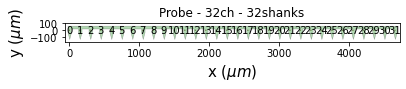

In [286]:
plot_probe(multi_shank, with_channel_index=True)

In [287]:
multi_shank.set_device_channel_indices(np.arange(32))

In [288]:
recording = recording.set_probes(multi_shank)

This extractor based on  neo.SpikeGadgetsRawIO have strange units not in (V, mV, uV) ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '']


- Old code that was used for using a probe with 32 channel columns

## Preprocessing

In [289]:
# Bandpass Filtering
recording_f = st.bandpass_filter(recording, freq_min=300, freq_max=6000)
print(recording_f)

BandpassFilterRecording: 32 channels - 1 segments - 20.0kHz - 3318.938s


In [290]:
recording_rm_noise = st.preprocessing.remove_bad_channels(recording_f)
print(recording_rm_noise)

RemoveBadChannelsRecording: 32 channels - 1 segments - 20.0kHz - 3318.938s


In [291]:
# Re-referencing
recording_cmr = st.common_reference(recording_rm_noise, reference='global', operator='median')
print(recording_cmr)


CommonReferenceRecording: 32 channels - 1 segments - 20.0kHz - 3318.938s


- Old preprocessing code

## Visualization and EDA

(11.0, 16.0, -2636.25, 84360.0)

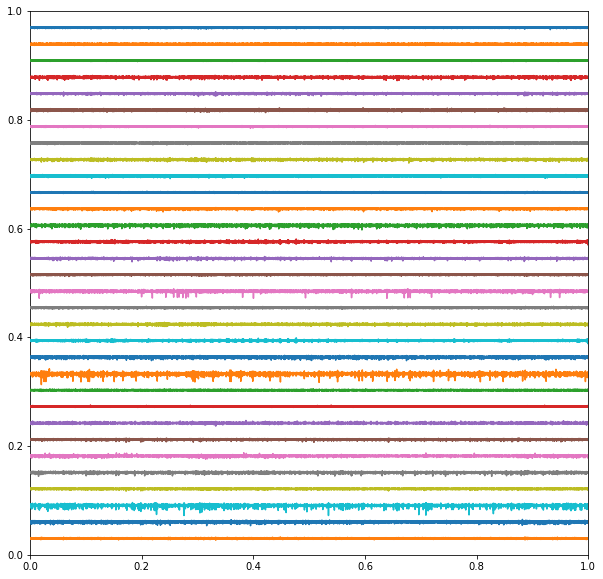

In [292]:
plt_kwargs = {'linewidth': 0.05}
fig, ax = plt.subplots(1,1, figsize=(10,10), **plt_kwargs)
sw.plot_timeseries(recording_cmr, time_range=[11,16], figure=fig)
plt.axis('off')

(11.0, 16.0, -854.25, 3417.0)

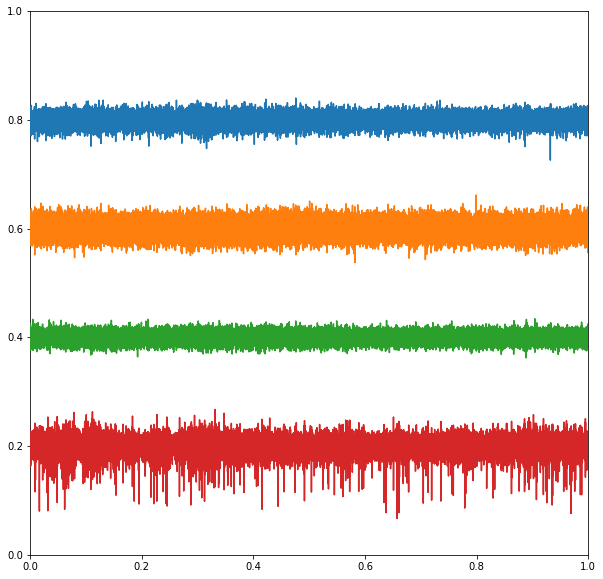

In [293]:
plt_kwargs = {'linewidth': 0.05}
fig, ax = plt.subplots(1,1, figsize=(10,10), **plt_kwargs)
sw.plot_timeseries(recording_cmr, time_range=[11,16], figure=fig,
                  channel_ids=['0', '1', '2', '3'])
plt.axis('off')

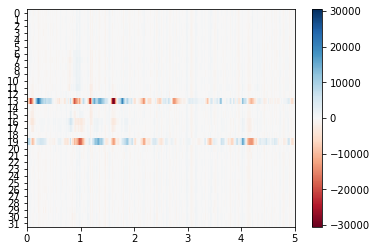

In [294]:
w_ts = sw.plot_timeseries(recording, time_range=(0, 5), mode="map", show_channel_ids=True,)


`ValueError: There is not Probe attached to recording. use set_probe(...)`

## Sorting

In [123]:
raise ValueError("Stop!")

ValueError: Stop!

Now you are ready to spike sort using the :code:`sorters` module!
Let's first check which sorters are implemented and which are installed



In [147]:
print('Available sorters', ss.available_sorters())
print('Installed sorters', ss.installed_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'klusta', 'mountainsort4', 'pykilosort', 'spykingcircus', 'tridesclous', 'waveclus', 'yass']
Installed sorters ['herdingspikes', 'mountainsort4', 'tridesclous']


The :code:`ss.installed_sorters()` will list the sorters installed in the machine.
We can see we have mountainsort4 and Tridesclous installed.
Spike sorters come with a set of parameters that users can change.
The available parameters are dictionaries and can be accessed with:



In [148]:
print(ss.get_default_params('mountainsort4'))

{'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'num_workers': 1, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10}


Let's run mountainsort4 and change one of the parameter, say, the detect_threshold:



In [296]:
ms4_params = ss.get_default_params('mountainsort4').copy()

In [298]:
ms4_params['adjacency_radius'] = 100
ms4_params['detect_sign'] = 0
ms4_params['filter'] = False
ms4_params['num_workers'] = 8
ms4_params['detect_interval'] = 30

In [299]:
import time

In [301]:
start = time.time()
sorting_ms4 = ss.run_mountainsort4(recording=recording_preprocessed,
                                  verbose=True,
                                   output_folder="./data/temp/ms4_sort/",
                                   **ms4_params)
print("Sorting finies in: ", time.time() - start)

whitenning
Mountainsort4 use the OLD spikeextractors mapped with RecordingExtractorOldAPI
Using 8 workers.
Using tmpdir: /tmp/tmp209_xoog
Num. workers = 8
Preparing /tmp/tmp209_xoog/timeseries.hdf5...
Preparing neighborhood sorters (M=32, N=66378757)...
Neighboorhood of channel 24 has 22 channels.
Detecting events on channel 25 (phase1)...
Neighboorhood of channel 18 has 32 channels.
Detecting events on channel 19 (phase1)...
Neighboorhood of channel 22 has 32 channels.
Detecting events on channel 23 (phase1)...
Neighboorhood of channel 28 has 22 channels.
Detecting events on channel 29 (phase1)...
Neighboorhood of channel 16 has 30 channels.
Detecting events on channel 17 (phase1)...
Neighboorhood of channel 25 has 24 channels.
Detecting events on channel 26 (phase1)...
Elapsed time for detect on neighborhood: 0:00:35.807408
Num events detected on channel 25 (phase1): 172605
Computing PCA features for channel 25 (phase1)...
Elapsed time for detect on neighborhood: 0:00:37.930793
Num e

Found 2 clusters for channel 18 (phase1)...
Computing templates for channel 18 (phase1)...
Elapsed time for detect on neighborhood: 0:00:37.050524
Num events detected on channel 7 (phase1): 227054
Computing PCA features for channel 7 (phase1)...
Elapsed time for detect on neighborhood: 0:00:38.684006
Num events detected on channel 32 (phase1): 216115
Computing PCA features for channel 32 (phase1)...
Elapsed time for detect on neighborhood: 0:00:48.843616
Num events detected on channel 24 (phase1): 214946
Computing PCA features for channel 24 (phase1)...
Re-assigning events for channel 18 (phase1)...
Neighboorhood of channel 20 has 30 channels.
Detecting events on channel 21 (phase1)...
Clustering for channel 6 (phase1)...
Found 2 clusters for channel 6 (phase1)...
Computing templates for channel 6 (phase1)...
Clustering for channel 7 (phase1)...
Clustering for channel 32 (phase1)...
Found 1 clusters for channel 32 (phase1)...
Computing templates for channel 32 (phase1)...
Re-assigning 

/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/neo/io/nixio.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_NIX_VER = Version("1.5.0")
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/neo/io/neomatlabio.py:30: DeprecationWarning: distutils Version classes are depr

Neighboorhood of channel 13 has 31 channels.
Computing PCA features for channel 14 (phase2)...
Neighboorhood of channel 6 has 22 channels.
Computing PCA features for channel 7 (phase2)...
Neighboorhood of channel 31 has 24 channels.
Computing PCA features for channel 32 (phase2)...
Neighboorhood of channel 28 has 22 channels.
Computing PCA features for channel 29 (phase2)...
Neighboorhood of channel 17 has 32 channels.
Computing PCA features for channel 18 (phase2)...
Neighboorhood of channel 27 has 23 channels.
Computing PCA features for channel 28 (phase2)...
No duplicate events found for channel 6 in phase2
Clustering for channel 7 (phase2)...
No duplicate events found for channel 27 in phase2
Clustering for channel 28 (phase2)...
Found 2 clusters for channel 7 (phase2)...
Neighboorhood of channel 3 has 23 channels.
Computing PCA features for channel 4 (phase2)...
No duplicate events found for channel 31 in phase2
Clustering for channel 32 (phase2)...
Found 2 clusters for channel 32

/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/neo/io/nixio.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_NIX_VER = Version("1.5.0")
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/matplotlib/__init__.py:202: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/neo/io/neomatlabio.py:30: DeprecationWarning: distutils Version classes are depr

Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmp209_xoog
mountainsort4 run time 1245.52s
Sorting finies in:  1245.546338558197


- TODO's
    - Look into what the parameters do(like freq_min)
    - Compare it with the original recording 
    - Plotting PC space and ISI(interspike interval interval)
    - Average wave form of each 
    - Look over Maya's video and follow her visualization

In [269]:
sorting_HS

NpzSortingExtractor: 46 units - 1 segments - 20.0kHz
  file_path: /home/riwata/Projects/spike_sorting/results/2022_03_25_salk_data_run/mountainsort4_output/firings.npz

Let's run tridesclous as well, with default parameters:



# TODO: Figure out what parameters I want for other sorter

In [151]:
start = time.time()
sorting_ms4 = ss.run_tridesclous(recording=recording_preprocessed,
                                  verbose=True,
                                   output_folder="./data/temp/tridesclous_sort/",)
print("Sorting finies in: ", time.time() - start)

/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/tridesclous/dataio.py:175: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v1 = distutils.version.LooseVersion(tridesclous_version).version
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/tridesclous/dataio.py:176: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v2 = distutils.version.LooseVersion(self.info['tridesclous_version']).version
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/setuptools

In [268]:
sorting_TDC

TridesclousSortingExtractor: 29 units - 1 segments - 20.0kHz

The :code:`sorting_HS` and :code:`sorting_TDC` are :code:`SortingExtractor`
objects. We can print the units found using:



In [152]:
print('Units found by mountainsort4:', sorting_HS.get_unit_ids())
print('Units found by tridesclous:', sorting_TDC.get_unit_ids())

Units found by mountainsort4: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Units found by tridesclous: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]


:code:`spikeinterface` provides a efficient way to extractor waveform snippets from paired recording/sorting objects.
The :code:`WaveformExtractor` class samples some spikes (:code:`max_spikes_per_unit=500`) for each cluster and stores
them on disk. These waveforms per cluster are helpful to compute the average waveform, or "template", for each unit
and then to compute, for example, quality metrics.



## Extracting Waveforms

- For Mountainsort

In [307]:
we_mountainsort = si.extract_waveforms(recording=recording_preprocessed, 
                                       sorting=sorting_ms4, folder='waveforms',
                                      ms_before=1, ms_after=1, progress_bar=True,
                                      n_jobs=8, total_memory="1G", overwrite=True)

extract waveforms: 100%|#####################| 34/34 [00:05<00:00,  6.73it/s]


In [308]:
we_mountainsort

WaveformExtractor: 32 channels - 77 units - 1 segments
  before:20 after20 n_per_units: 500

In [309]:
mask = np.array(list(st.compute_snrs(we_mountainsort).values())) > 4

In [311]:
sorting_ms4.get_unit_ids()[mask]

array([ 4,  5,  6,  8,  9, 10, 11, 13, 15, 16, 17, 19, 20, 21, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 45, 46, 47,
       48, 49, 50, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70,
       71, 72, 73, 74, 75, 76])

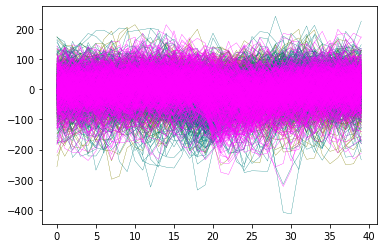

In [317]:
colors = ['Olive', 'Teal', 'Fuchsia']

fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_ms4.unit_ids[4:7]):
    wf = we_mountainsort.get_waveforms(unit_id)
    color = colors[i]
    ax.plot(wf[:, :, 8].T, color=color, lw=0.3)

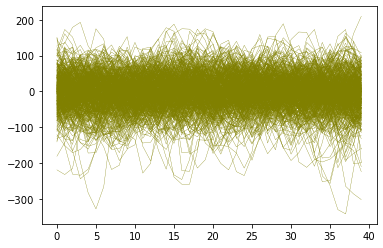

In [320]:
colors = ['Olive', 'Teal', 'Fuchsia']

fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_ms4.unit_ids[:1]):
    wf = we_mountainsort.get_waveforms(unit_id)
    color = colors[i]
    ax.plot(wf[:, :, 8].T, color=color, lw=0.3)

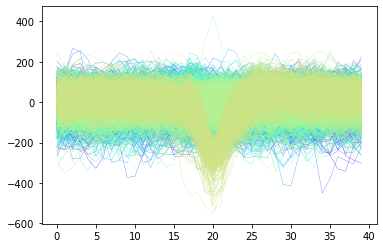

In [400]:
colors = iter(cm.rainbow(np.linspace(0, 1, n)))

fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_ms4.unit_ids[:16]):
    wf = we_mountainsort.get_waveforms(unit_id)
    color = next(colors)
    ax.plot(wf[:, :, 8].T, color=color, lw=0.3)

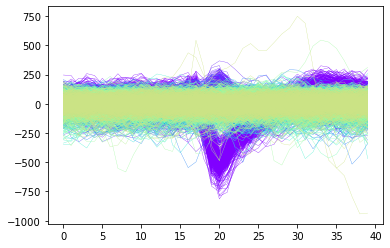

In [401]:
colors = iter(cm.rainbow(np.linspace(0, 1, n)))

fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_ms4.unit_ids[16:32]):
    wf = we_mountainsort.get_waveforms(unit_id)
    color = next(colors)
    ax.plot(wf[:, :, 8].T, color=color, lw=0.3)

In [323]:
from matplotlib.pyplot import cm
import numpy as np

In [ ]:

#variable n below should be number of curves to plot

#version 1:

color = cm.rainbow(np.linspace(0, 1, n))
for i, c in zip(range(n), color):
   plt.plot(x, y, c=c)

#or version 2:

color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range(n):
   c = next(color)
   plt.plot(x, y, c=c)

- To Keep:
    8
    15
    16
    18`

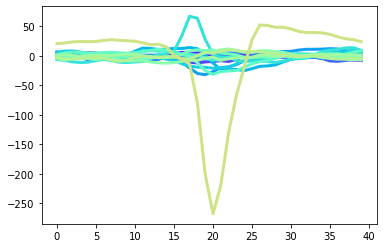

In [392]:
colors = iter(cm.rainbow(np.linspace(0, 1, n)))
fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_ms4.unit_ids[0:16]):
    template = we_mountainsort.get_template(unit_id)
    color = next(colors)
    ax.plot(template[:, 8].T, color=color, lw=3)

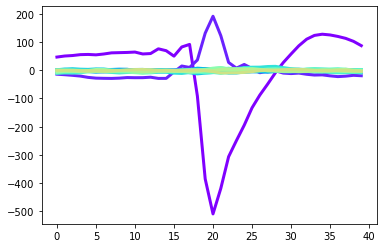

In [393]:
colors = iter(cm.rainbow(np.linspace(0, 1, n)))
fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_ms4.unit_ids[16:32]):
    template = we_mountainsort.get_template(unit_id)
    color = next(colors)
    ax.plot(template[:, 8].T, color=color, lw=3)

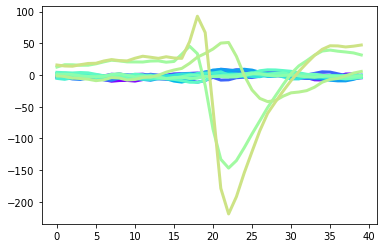

In [394]:
colors = iter(cm.rainbow(np.linspace(0, 1, n)))
fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_ms4.unit_ids[32:48]):
    template = we_mountainsort.get_template(unit_id)
    color = next(colors)
    ax.plot(template[:, 8].T, color=color, lw=3)

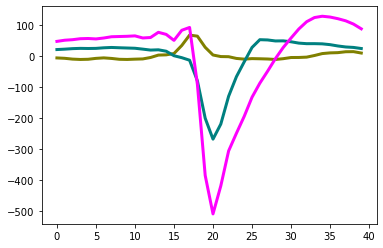

In [396]:
colors = ['Olive', 'Teal', 'Fuchsia']
fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_ms4.unit_ids[[8,15,16]]):
    template = we_mountainsort.get_template(unit_id)
    color = colors[i]
    ax.plot(template[:, 8].T, color=color, lw=3)

WaveformPrincipalComponent: 32 channels - 1 segments
  mode:by_channel_local n_components:3
(500, 3, 32)
(500, 3, 32)
(500, 3, 32)


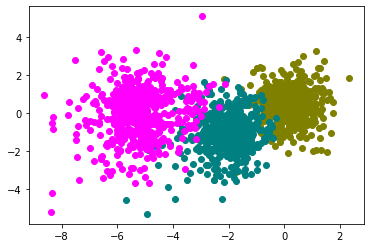

In [397]:
colors = ['Olive', 'Teal', 'Fuchsia']
pc = st.compute_principal_components(we_mountainsort, load_if_exists=True,
                                     n_components=2, mode='by_channel_local')
print(pc)

fig, ax = plt.subplots()
for i, unit_id in enumerate(sorting_ms4.unit_ids[[8,15,16]]):
    comp = pc.get_components(unit_id)
    print(comp.shape)
    color = colors[i]
    ax.scatter(comp[:, 0, 8], comp[:, 1, 8], color=color)

In [ ]:
we_TDC = si.WaveformExtractor.create(recording_preprocessed, sorting_TDC, 'waveforms', remove_if_exists=True)
we_TDC.set_params(ms_before=3., ms_after=4., max_spikes_per_unit=500)
we_TDC.run_extract_waveforms(n_jobs=-1, chunk_size=30000)
print(we_TDC)

- Old Waveform extractor code

In [153]:
we_TDC = si.WaveformExtractor.create(recording_preprocessed, sorting_TDC, 'waveforms', remove_if_exists=True)
we_TDC.set_params(ms_before=3., ms_after=4., max_spikes_per_unit=500)
we_TDC.run_extract_waveforms(n_jobs=-1, chunk_size=30000)
print(we_TDC)

unit_id0 = sorting_TDC.unit_ids[0]
wavefroms = we_TDC.get_waveforms(unit_id0)
print(wavefroms.shape)

template = we_TDC.get_template(unit_id0)
print(template.shape)

WaveformExtractor: 32 channels - 29 units - 1 segments
  before:60 after80 n_per_units: 500
(500, 140, 32)
(140, 32)


Once we have the  `WaveformExtractor` object
we can post-process, validate, and curate the results. With
the :code:`toolkit.postprocessing` submodule, one can, for example,
get waveforms, templates, maximum channels, PCA scores, or export the data
to Phy. `Phy <https://github.com/cortex-lab/phy>`_ is a GUI for manual
curation of the spike sorting output. To export to phy you can run:



In [154]:
from spikeinterface.exporters import export_to_phy

export_to_phy(we_TDC, './phy_folder_for_TDC',
              compute_pc_features=False, compute_amplitudes=True)

write_binary_recording with n_jobs 1  chunk_size None


/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/tridesclous/dataio.py:175: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v1 = distutils.version.LooseVersion(tridesclous_version).version
/home/riwata/Projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/tridesclous/dataio.py:176: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v2 = distutils.version.LooseVersion(self.info['tridesclous_version']).version


Run:
phy template-gui  /home/riwata/Projects/spike_sorting/results/2022_03_25_salk_data_run/phy_folder_for_TDC/params.py


Then you can run the template-gui with: :code:`phy template-gui phy/params.py`
and manually curate the results.



Quality metrics for the spike sorting output are very important to asses the spike sorting performance.
The :code:`spikeinterface.toolkit.qualitymetrics` module implements several quality metrics
to assess the goodness of sorted units. Among those, for example,
are signal-to-noise ratio, ISI violation ratio, isolation distance, and many more.
Theses metrics are built on top of WaveformExtractor class and return a dictionary with the unit ids as keys:



In [155]:
st.compute_isi_violations(we_TDC, isi_threshold_ms=1.5)

isi_violaion(isi_violations_rate={0: 0.03495094070532234, 1: 0.0, 2: 0.1566766307479967, 3: 0.03254053100150701, 4: 0.5438486894233346, 5: 0.5158276766164814, 6: 0.0018078072778615003, 7: 0.0024104097038153338, 8: 1.5978003324165893, 9: 2.1482776485254163, 10: 0.7011279225972852, 11: 0.12353349732053585, 12: 0.29406998386547073, 13: 0.20759653574109563, 14: 0.016872867926707336, 15: 0.48599885653176667, 16: 0.5248667130057889, 17: 0.3124493578570626, 18: 0.8291809381124748, 19: 0.12504000338542043, 20: 0.0647797607900371, 21: 0.1135905572922976, 22: 0.05122120620607584, 23: 0.2003653066296496, 24: 0.0018078072778615003, 25: 0.02109108490838417, 26: 0.16692087198921185, 27: 0.35402892524787716, 28: 0.2955764899303553}, isi_violations_count={0: 116, 1: 0, 2: 520, 3: 108, 4: 1805, 5: 1712, 6: 6, 7: 8, 8: 5303, 9: 7130, 10: 2327, 11: 410, 12: 976, 13: 689, 14: 56, 15: 1613, 16: 1742, 17: 1037, 18: 2752, 19: 415, 20: 215, 21: 377, 22: 170, 23: 665, 24: 6, 25: 70, 26: 554, 27: 1175, 28: 981}

In [156]:
snrs = st.compute_snrs(we_TDC)
print(snrs)
isi_violations_rate, isi_violations_count = st.compute_isi_violations(we_TDC, isi_threshold_ms=1.5)
print(isi_violations_rate)
print(isi_violations_count)

{0: 21.870662499999998, 1: 14.951416666666667, 2: 13.091431818181817, 3: 3.738657142857143, 4: 6.104225, 5: 7.219648148148148, 6: 5.595851851851852, 7: 5.42298, 8: 7.299588888888889, 9: 10.1006375, 10: 6.40775, 11: 7.884672413793103, 12: 5.600393939393939, 13: 5.974142857142858, 14: 5.545888888888888, 15: 7.08225, 16: 6.070499999999999, 17: 6.69175, 18: 6.459634615384616, 19: 5.814655172413793, 20: 5.702590909090908, 21: 5.88164, 22: 7.319574074074073, 23: 6.223795454545454, 24: 5.702590909090908, 25: 5.620833333333333, 26: 5.579954545454545, 27: 5.828371794871795, 28: 5.6658}
{0: 0.03495094070532234, 1: 0.0, 2: 0.1566766307479967, 3: 0.03254053100150701, 4: 0.5438486894233346, 5: 0.5158276766164814, 6: 0.0018078072778615003, 7: 0.0024104097038153338, 8: 1.5978003324165893, 9: 2.1482776485254163, 10: 0.7011279225972852, 11: 0.12353349732053585, 12: 0.29406998386547073, 13: 0.20759653574109563, 14: 0.016872867926707336, 15: 0.48599885653176667, 16: 0.5248667130057889, 17: 0.312449357857

All theses quality metrics can be computed in one shot and returned as
a :code:`pandas.Dataframe`



In [157]:
metrics = st.compute_quality_metrics(we_TDC, metric_names=['snr', 'isi_violation', 'amplitude_cutoff'])
print(metrics)

          snr  isi_violations_rate  isi_violations_count  amplitude_cutoff
0   21.870662             0.034951                   116          0.000518
1   14.951417             0.000000                     0          0.008518
2   13.091432             0.156677                   520          0.005133
3    3.738657             0.032541                   108          0.010518
4    6.104225             0.543849                  1805          0.004799
5    7.219648             0.515828                  1712          0.000518
6    5.595852             0.001808                     6          0.000518
7    5.422980             0.002410                     8          0.000518
8    7.299589             1.597800                  5303          0.000528
9   10.100637             2.148278                  7130          0.000518
10   6.407750             0.701128                  2327          0.000518
11   7.884672             0.123533                   410          0.000518
12   5.600394            

Quality metrics can be also used to automatically curate the spike sorting
output. For example, you can select sorted units with a SNR above a
certain threshold:



In [158]:
keep_mask = (metrics['snr'] > 7.5) & (metrics['isi_violations_rate'] < 0.01)
print(keep_mask)

keep_unit_ids = keep_mask[keep_mask].index.values
print(keep_unit_ids)

curated_sorting = sorting_TDC.select_units(keep_unit_ids)
print(curated_sorting)

0     False
1      True
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
dtype: bool
[1]
UnitsSelectionSorting: 1 units - 1 segments - 20.0kHz


The final part of this tutorial deals with comparing spike sorting outputs.
We can either (1) compare the spike sorting results with the ground-truth
sorting :code:`sorting_true`, (2) compare the output of two (mountainsort4
and Tridesclous), or (3) compare the output of multiple sorters:



In [160]:
comp_gt_TDC = sc.compare_sorter_to_ground_truth(gt_sorting=sorting_true, tested_sorting=sorting_TDC)
comp_TDC_HS = sc.compare_two_sorters(sorting1=sorting_TDC, sorting2=sorting_HS)
comp_multi = sc.compare_multiple_sorters(sorting_list=[sorting_TDC, sorting_HS],
                                         name_list=['tdc', 'hs'])

NameError: name 'sorting_true' is not defined

When comparing with a ground-truth sorting extractor (1), you can get the sorting performance and plot a confusion
matrix



In [161]:
comp_gt_TDC.get_performance()
w_conf = sw.plot_confusion_matrix(comp_gt_TDC)
w_agr = sw.plot_agreement_matrix(comp_gt_TDC)

NameError: name 'comp_gt_TDC' is not defined

When comparing two sorters (2), we can see the matching of units between sorters.
Units which are not matched has -1 as unit id:



In [27]:
comp_TDC_HS.hungarian_match_12

0     2
1    18
2     4
3     7
4    13
5    -1
6    12
7    16
8     6
9    15
dtype: int64

or the reverse:



In [28]:
comp_TDC_HS.hungarian_match_21

1    -1
2     0
3    -1
4     2
5    -1
6     8
7     3
8    -1
9    -1
10   -1
11   -1
12    6
13    4
14   -1
15    9
16    7
17   -1
18    1
19   -1
20   -1
dtype: int64

When comparing multiple sorters (3), you can extract a :code:`SortingExtractor` object with units in agreement
between sorters. You can also plot a graph showing how the units are matched between the sorters.



In [162]:
sorting_agreement = comp_multi.get_agreement_sorting(minimum_agreement_count=2)

print('Units in agreement between Klusta and Mountainsort4:', sorting_agreement.get_unit_ids())

w_multi = sw.plot_multicomp_graph(comp_multi)

plt.show()

NameError: name 'comp_multi' is not defined